In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax
import optax

jax.config.update("jax_enable_x64", True)

from time import time

import matplotlib.pyplot as plt

from functools import partial
from datetime import datetime

from util import run_opt

Not sure why, but need at least 3 segments for arbitrary single qubit gates

In [2]:
wires = [0]
sim = qml.device("default.qubit.jax", wires=wires)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
T = 100 # ns
qubit_freq = 2*np.pi*np.array([4.6,])

tbins = 2
tphis = tbins

def normalize(x):
    """Differentiable normalization to +/- 1 outputs (shifted sigmoid)"""
    return (1 - jnp.exp(-x))/(1 + jnp.exp(-x))

def drive_field(T, wd):
    def wrapped(p, t):
        """ callable phi with ``tbins`` slots """
        # The first len(p)-1 values of the trainable params p characterize the pwc function
        amp = qml.pulse.pwc(T)(p[:tbins], t)
        # The amplitude is normalized to maximally reach +/-20MHz (0.02GHz)
        # amp = max_amp*normalize(amp)
        phi = qml.pulse.pwc(T)(p[tbins:], t)
        return amp * jnp.sin(wd * t + phi)

    return wrapped

H0 = -qubit_freq[0]/2 * qml.PauliZ(0)
Hd0 = drive_field(T, qubit_freq[0]) * qml.PauliY(0)
H = H0 + Hd0

def comp_u(params):
    return qml.matrix(qml.evolve(H)(params, t=T, atol=1e-12))

def loss(params, target=qml.matrix(qml.PauliX(0))):
    U = comp_u(params)
    V = target
    return 1 - jnp.abs(jnp.trace(U.conj().T @ V))/len(U)

key = jax.random.PRNGKey(42)
theta = jax.random.normal(key, shape=(1, tbins+tphis))

loss(theta)

Array(0.7577362, dtype=float64)

# Compile Pauli Y gate

In [5]:
loss0 = partial(loss, target=qml.matrix(qml.PauliY(0)))
value_and_grad_jax = jax.jit(jax.value_and_grad(loss0))

In [6]:
seed = 0

key = jax.random.PRNGKey(seed)
theta = jax.random.normal(key, shape=(1, tbins+tphis))
thetas, energy, gradients = run_opt(value_and_grad_jax, theta, lr=0.1, b1=0.9, b2=0.999)

final loss: 2.002845471893444e-05; min loss: 9.822558787453417e-06; after 0:00:12.069347


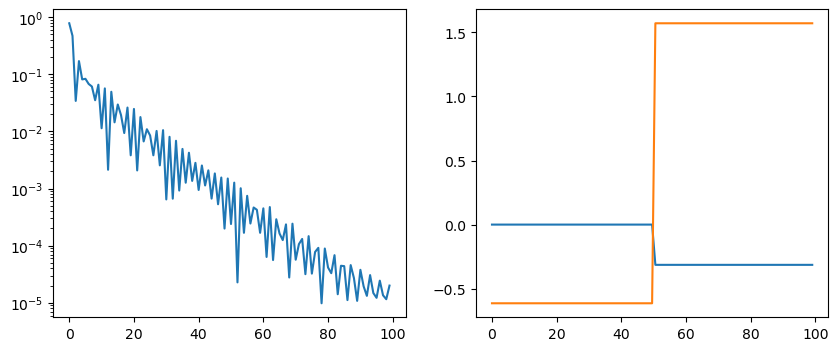

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

thetaf = thetas[-1]

ax = axs[0]
ax.plot(energy)
ax.set_yscale("log")

ax = axs[1]
ts = np.linspace(0, T, 100)
ax.plot(ts[:-1], qml.pulse.pwc(T)(thetaf[0, :tbins], ts)[:-1])
ax.plot(ts[:-1], qml.pulse.pwc(T)(thetaf[0, tbins:], ts)[:-1])

In [10]:
@jax.jit
def recomp(w):
    H0 = -qubit_freq[0]/2 * qml.PauliZ(0)
    Hd0 = drive_field(T, w) * qml.PauliY(0)
    H = H0 + Hd0

    def comp_u(params):
        return qml.matrix(qml.evolve(H)(params, t=T, atol=1e-12))

    def loss(params, target=qml.matrix(qml.PauliY(0))):
        U = comp_u(params)
        V = target
        return 1 - jnp.abs(jnp.trace(U.conj().T @ V))/len(U)
    return loss(thetaf)

In [11]:
ws0 = jnp.linspace(-0.6*2*jnp.pi, 0.6*2*jnp.pi, 1000) + qubit_freq[0]
y0 = jax.vmap(recomp)(ws0)

In [12]:
ws1 = jnp.linspace(-0.1*2*jnp.pi, 0.1*2*jnp.pi, 10000) + qubit_freq[0]
y1 = jax.vmap(recomp)(ws1)

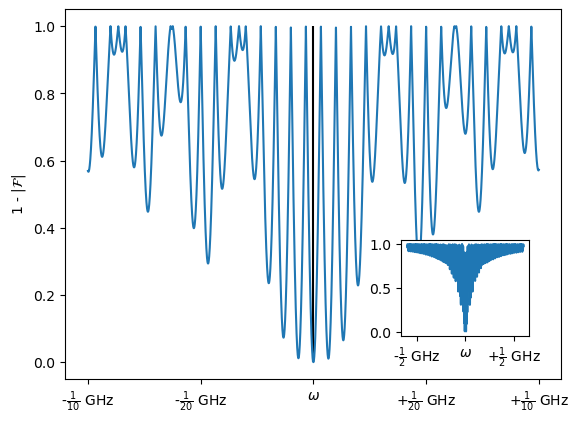

In [13]:
fig, ax = plt.subplots()
ax.vlines([qubit_freq], 0, 1, color="k")

ax.plot(ws1, y1)
ax.set_xticks([qubit_freq[0] - 0.1*2*np.pi, qubit_freq[0] - 0.05*2*np.pi, qubit_freq[0], qubit_freq[0] + 0.05*2*np.pi, qubit_freq[0] + 0.1*2*np.pi], ["-$\\frac{{1}}{{10}}$ GHz", "-$\\frac{{1}}{{20}}$ GHz", "$\\omega$", "+$\\frac{{1}}{{20}}$ GHz", "+$\\frac{{1}}{{10}}$ GHz"])
ax.set_ylabel("1 - |$\\mathcal{F}$|")

left, bottom, width, height = [0.65, 0.2, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(ws0, y0)
ax2.set_xticks([qubit_freq[0] - 0.5*2*np.pi, qubit_freq[0], qubit_freq[0] + 0.5*2*np.pi], ["-$\\frac{{1}}{{2}}$ GHz", "$\\omega$", "+$\\frac{{1}}{{2}}$ GHz"])
